# 2. Association Analysis

Summary of the steps taken to identify any genetic variants that are associated with early onset of pancreatic cancer (EOPC) status:
1. ***Preparing data for modeling:***
   
    I first explored whether any other features were associated with pancreatic cancer status (age, ancestry, smoking history, bmi, sex). Initial analysis suggests that both **ancestry** and **smoking history** are associated with pancreatic cancer risk in this dataset. Using Chi-square tests of independence, I obtained the following results:
    
    | Risk Factor       | Chi-square | p-value         
    |------------------|------------|-----------------|
    | Ancestry          | $77.08$   | $7.23 × 10^{-16}$|
    | Smoking History   | $13.21$   | $0.00135$| 
    
    
    Non-reference allele counts were then removed from *219* patients who had no recorded smoking history. *495* variants were then removed from the analysis due to missing values and then *85* variants due to monomorphic non-reference allele counts.

    Therefore, the processed non-reference allele counts had a size of 2,784 variants × 1,145 patients.

2. ***Modeling:***

    A separate logistic regression model with Lasso (L1) regression was used to represent each genetic variant. This means that there were a total of 2,784 logistic regression models, each modeled with 3 predictors (non-reference allele count, ancestry, and smoking history) with the output being whether the individual had EOPC. The p-values and coefficients ($\beta$) were then extracted from each of these models. The thought here is that, for instance, the non-reference allele count p-value will represent whether the non-reference allele count for that variant is associated with EOPC status. The odds ratio was also calculated using the $\beta$ values for non-reference allele count.
    
    The results for the top 100 variants associated with EOPC risk have been exported to the `results` folder as `top_100_variants.tsv`. 

3. ***Visualization & Interpretation:***

    A Manhattan plot was generated to visualize the association of the 2,784 genetic variants to EOPC status (also at `results/manhattan_plot.png`). The top 8 genetic variants (all with $p < 1x10^{-8}$) associated with EOPC risk have been annotated with their position on chromosome 18.

## a. Exploring other features

In [1]:
# import the data manipulation tools
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
# import chi-square test
from scipy.stats import chi2_contingency

In [3]:
# import the sample phenotypes
sample_phenotypes = pd.read_csv("data/raw/phenotypes.tsv", sep='\t', index_col=0)
sample_phenotypes.head()

,pancreas_cancer,age,ancestry,smoking_history,bmi,sex,PC1,PC2,PC3,PC4,PC5
#sample_id,,,,,,,,,,,
BGC_000034,0,48.0,EUR,0.0,27.8,1,-0.0120,0.0174,0.0085,-0.0179,0.0003
BGC_000052,0,44.0,EUR,NaN,30.4,1,-0.0096,0.0236,0.0120,-0.0197,-0.0033
BGC_000069,0,48.0,EAS,0.0,27.5,2,-0.0128,-0.0294,0.0047,-0.0055,-0.0014
BGC_000071,0,62.0,EUR,0.0,25.7,2,-0.0108,0.0191,0.0053,-0.0148,-0.0008
BGC_000083,0,45.0,EUR,0.0,30.5,1,-0.0110,0.0223,0.0112,-0.0130,-0.0003


In [4]:
# testing if ancestry is associated with pancreatic cancer --> yes
eopc_ancestry = pd.crosstab(sample_phenotypes["pancreas_cancer"], sample_phenotypes["ancestry"])
chi2, p, dof, expected = chi2_contingency(eopc_ancestry)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 77.08172931328586
p-value: 7.227054234222006e-16


In [5]:
eopc_ancestry

ancestry,AFR,AMR,EAS,EUR,SAS
pancreas_cancer,,,,,
0,193,68,156,354,120
1,194,14,64,119,82


In [6]:
# testing if smoking history is associated with pancreatic cancer --> yes, but seems less so than ancestry 
eopc_smoking = pd.crosstab(sample_phenotypes["pancreas_cancer"], sample_phenotypes["smoking_history"])
chi2, p, dof, expected = chi2_contingency(eopc_smoking)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 13.211550564436221
p-value: 0.0013525341713786939


In [7]:
eopc_smoking

smoking_history,0.0,1.0,2.0
pancreas_cancer,,,
0,630,53,67
1,297,46,52


In [8]:
# testing if sex is associated with pancreatic cancer --> no difference
eopc_smoking = pd.crosstab(sample_phenotypes["pancreas_cancer"], sample_phenotypes["sex"])
chi2, p, dof, expected = chi2_contingency(eopc_smoking)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 0.0
p-value: 1.0


In [9]:
# import data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# set the parameters that control the scaling of plot elements
sns.set_context("poster")

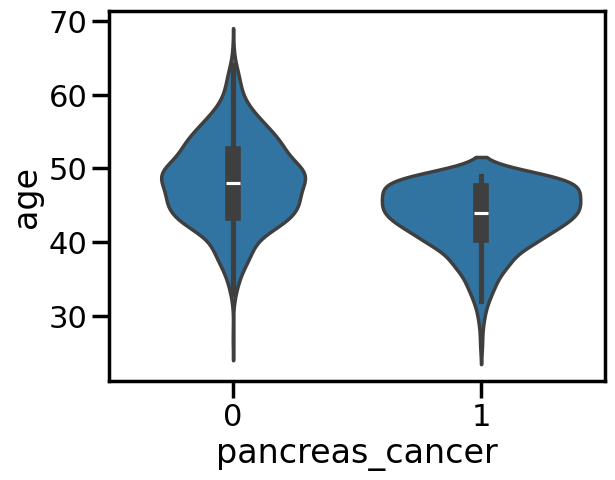

In [11]:
# checking if there seems to be any difference in age across EOPC status --> doesn't seem to be a significant difference
sns.violinplot(sample_phenotypes, x="pancreas_cancer", y="age")
plt.show()

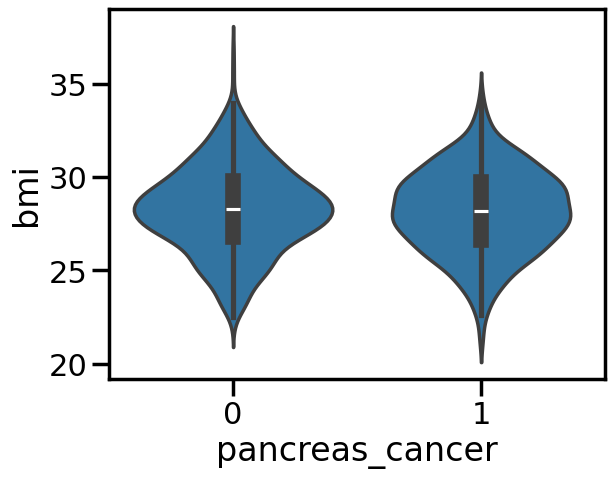

In [12]:
# checking if there seems to be any difference in age across EOPC status --> doesn't seem to be much of a difference
sns.violinplot(sample_phenotypes, x="pancreas_cancer", y="bmi")
plt.show()

Initial analysis suggests that both **ancestry** and **smoking history** are associated with pancreatic cancer risk in this dataset. Using Chi-square tests of independence, I obtained the following results:

| Risk Factor       | Chi-square | p-value           | Interpretation |
|------------------|------------|-----------------|----------------|
| Ancestry          | $77.08$      | $7.23 × 10^{-16}$    | Strongly associated with pancreatic cancer |
| Smoking History   | $13.21$      | $0.00135$         | Significantly associated, but less strongly than ancestry |

In [13]:
# store relevant features
relevant_features = sample_phenotypes[["pancreas_cancer", "ancestry", "smoking_history"]]
# convert the ancestry to numerical values
ancestry2nums = {
    "EUR": 1,
    "EAS": 2,
    "SAS": 3,
    "AFR": 4,
    "AMR": 5}
relevant_features["ancestry"] = relevant_features["ancestry"].replace(ancestry2nums)

# remove samples with no smoking history 
relevant_features = relevant_features[relevant_features["smoking_history"].notna()]
print("# of individuals removed:", sample_phenotypes.shape[0]-relevant_features.shape[0])
relevant_features

# of individuals removed: 219


/var/folders/0g/f33h1kwn62d9xw1_72cq2zxh0000gn/T/ipykernel_43292/4024144367.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relevant_features["ancestry"] = relevant_features["ancestry"].replace(ancestry2nums)
/var/folders/0g/f33h1kwn62d9xw1_72cq2zxh0000gn/T/ipykernel_43292/4024144367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_features["ancestry"] = relevant_features["ancestry"].replace(ancestry2nums)


,pancreas_cancer,ancestry,smoking_history
#sample_id,,,
BGC_000034,0,1,0.0
BGC_000069,0,2,0.0
BGC_000071,0,1,0.0
BGC_000083,0,1,0.0
BGC_000086,0,3,2.0
...,...,...,...
PCiYP00991,1,5,2.0
PCiYP00993,1,3,0.0
PCiYP00994,1,2,0.0


## b. Processing data for modeling

In [14]:
# import the allele count matrix
allele_counts = pd.read_csv("data/processed/allele_counts.tsv", sep='\t', index_col="ID")
cols = ["CHROM", "POS", "ALT", "TYPE"] + relevant_features.index.tolist()
filt_allele_counts = allele_counts.loc[:, cols]
filt_allele_counts

,CHROM,POS,ALT,TYPE,BGC_000034,BGC_000069,BGC_000071,BGC_000083,BGC_000086,BGC_000091,...,PCiYP00984,PCiYP00986,PCiYP00988,PCiYP00989,PCiYP00990,PCiYP00991,PCiYP00993,PCiYP00994,PCiYP00995,PCiYP00999
ID,,,,,,,,,,,,,,,,,,,,,
chr18_15051_A_G,chr18,15051,G,SNP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_52006_G_T,chr18,52006,T,SNP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_54257_A_G,chr18,54257,G,SNP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_86571_A_G,chr18,86571,G,SNP,1.0,1.0,0.0,0.0,1.0,2.0,...,2.0,2.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0
chr18_111667_C_A,chr18,111667,A,SNP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr18_80133824_CGTT_C,chr18,80133824,C,INDEL,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_80210807_A_T,chr18,80210807,T,SNP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_80235608_G_A,chr18,80235608,A,SNP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# calculate the % of missing values for each variant
nan_percent_per_variant = filt_allele_counts.isna().mean(axis=1) * 100
nan_percent_per_variant.describe()

count    3364.000000
mean        1.361236
std         6.699272
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        98.172324
dtype: float64

In [16]:
# number of variants with missing values
print((nan_percent_per_variant > 0).sum())

495


In [17]:
# removing any variants with missing values
filt_allele_counts = filt_allele_counts.dropna(axis=0, how="any")
# remove the columns containing information about the variant
variant_info = ["CHROM", "POS", "ALT", "TYPE"]
filt_allele_counts = filt_allele_counts.drop(variant_info, axis=1)
filt_allele_counts

,BGC_000034,BGC_000069,BGC_000071,BGC_000083,BGC_000086,BGC_000091,BGC_000113,BGC_000150,BGC_000183,BGC_000248,...,PCiYP00984,PCiYP00986,PCiYP00988,PCiYP00989,PCiYP00990,PCiYP00991,PCiYP00993,PCiYP00994,PCiYP00995,PCiYP00999
ID,,,,,,,,,,,,,,,,,,,,,
chr18_15051_A_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_86571_A_G,1.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,...,2.0,2.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0
chr18_111667_C_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
chr18_119927_A_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_154192_G_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr18_80096657_A_G,1.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0
chr18_80133824_CGTT_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_80210807_A_T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# store the number of variants with a total non-reference allele count are all monomorphic
monomorphic_variants = filt_allele_counts.apply(lambda row: row.nunique() == 1, axis=1)

# filter out these variants
print("Number of variants with monomorphic non-reference allele counts:", monomorphic_variants.sum())
filt_allele_counts = filt_allele_counts[~monomorphic_variants]
filt_allele_counts

Number of variants with monomorphic non-reference allele counts: 85


,BGC_000034,BGC_000069,BGC_000071,BGC_000083,BGC_000086,BGC_000091,BGC_000113,BGC_000150,BGC_000183,BGC_000248,...,PCiYP00984,PCiYP00986,PCiYP00988,PCiYP00989,PCiYP00990,PCiYP00991,PCiYP00993,PCiYP00994,PCiYP00995,PCiYP00999
ID,,,,,,,,,,,,,,,,,,,,,
chr18_15051_A_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_86571_A_G,1.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,...,2.0,2.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0
chr18_111667_C_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
chr18_119927_A_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_154192_G_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr18_80096657_A_G,1.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0
chr18_80133824_CGTT_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr18_80210807_A_T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## c. Modeling

I want to create a logistic regression model for each variant that predicts for EOPC based on non-reference allele count, non-reference allele count, ancestry, and smoking history. Mathematically, each variant model can be represented as:
$$
\text{logit}(y_{eopc}) = \beta_0 + \beta_1 x_{genotype} + \beta_2 x_{ancestry} + \beta_3 x_{smoking}
$$
where
* $y_{variant}$ = has or does not have early onset of pancreatic cancer
* $x_{genotype}$ = non-reference allele count
* $x_{ancestry}$ = continental ancestry label
* $x_{smoking}$ = smoking history where 2 = current smoker, 1 = former smoker, 0 = no smoking history

***NOTE:*** There were some variants with little variance in non-reference allele counts based on pancreatic cancer status and so I've performed a *Lasso (L1) regularization*.

In [19]:
## create a function to determine if a genetic variant is associated with early onset of pancreatic cancer 
def compute_variant_assoc(variant):
    # create a dataframe containing the relevant information for the variant of interest
    variant_counts = filt_allele_counts.loc[variant].reset_index()
    variant_counts.columns = ["#sample_id", "allele_count"]
    variant_data = pd.merge(variant_counts, relevant_features, on="#sample_id")
    variant_data.set_index("#sample_id", inplace=True)
    
    # define inputs and outputs
    y = variant_data["pancreas_cancer"]
    Xtrain = variant_data.drop("pancreas_cancer", axis=1)
    # add constant column
    X = sm.add_constant(Xtrain)
    
    
    # fit a logistic regression model to this variant data
    variant_model = sm.Logit(y, X)
    # variant_results = variant_model.fit()
    variant_results = variant_model.fit_regularized(method="l1")
    
    # extract the p-value for the variant
    variant_ps = variant_results.pvalues[1:]
    variant_betas = variant_results.params[1:]
    
    return variant_data, variant_model, variant_results, variant_ps, variant_betas

In [20]:
## create a dictionaries to store all outputs from analysis
all_variant_data = {}
all_variant_models = {}
all_variant_results = {}

## create a list containing list of all variants
all_variants = filt_allele_counts.index
## create dataframes to store the relevant p-values and beta values
cols = ["allele_count", "ancestry", "smoking_history"]
all_variant_ps = pd.DataFrame(columns=cols, index=all_variants)
all_variant_betas = pd.DataFrame(columns=cols, index=all_variants)

## iterate through each variant
for variant in all_variants:
    # and determine if a genetic variant is associated with early onset of pancreatic cancer
    # store all relevant information into the dictionaries/dataframes above for future access
    all_variant_data[variant], all_variant_models[variant], all_variant_results[variant], variant_ps, variant_betas = compute_variant_assoc(variant)
    all_variant_ps.loc[variant] = variant_ps
    all_variant_betas.loc[variant] = variant_betas

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6266638825614487
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6289921679039447
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6285511942794298
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6279362280048499
            Iterations: 49
            Function evaluations: 50
            Gradient evaluations: 49
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6286353103339746
            Iterations: 20
            Function eva

In [21]:
# convert all p-values and beta values to numeric values
all_variant_ps = all_variant_ps.apply(pd.to_numeric)
all_variant_betas = all_variant_betas.apply(pd.to_numeric)
# rename columns
all_variant_ps.columns = [f"p_{col}" for col in cols]
all_variant_betas.columns = [f"beta_{col}" for col in cols]

# create a new dataframe containing the variant information and p-values 
variant_assoc = pd.merge(allele_counts.loc[all_variants, variant_info], all_variant_ps["p_allele_count"], on="ID")
# add a column containing the -log(p-value) values for each variant
variant_assoc["-log(p_allele_count)"] = - np.log(variant_assoc["p_allele_count"])
# add the beta values to this dataframe
variant_assoc = pd.merge(variant_assoc, all_variant_betas["beta_allele_count"], on="ID")
# add a column with with log-odds ratio for each variant
variant_assoc["odds_ratio_allele_count"] = np.exp(variant_assoc["beta_allele_count"])
# sort this data from most to least strongly to associated with EOPC
variant_assoc = variant_assoc.sort_values("p_allele_count", ascending=True)
variant_assoc

,CHROM,POS,ALT,TYPE,p_allele_count,-log(p_allele_count),beta_allele_count,odds_ratio_allele_count
ID,,,,,,,,
chr18_26157915_C_T,chr18,26157915,T,SNP,5.949263e-10,21.242584,0.847623,2.334092e+00
chr18_3336078_AT_A,chr18,3336078,A,INDEL,1.560663e-06,13.370400,0.522429,1.686118e+00
chr18_45877886_C_T,chr18,45877886,T,SNP,3.283872e-06,12.626487,0.434891,1.544795e+00
chr18_13929779_G_A,chr18,13929779,A,SNP,1.261143e-05,11.280907,0.827575,2.287765e+00
chr18_69861194_C_T,chr18,69861194,T,SNP,2.850595e-05,10.465398,-0.382328,6.822715e-01
...,...,...,...,...,...,...,...,...
chr18_29574420_C_T,chr18,29574420,T,SNP,9.995212e-01,0.000479,-20.610432,1.119446e-09
chr18_15322671_G_C,chr18,15322671,C,SNP,9.995212e-01,0.000479,-20.610432,1.119446e-09
chr18_68880140_C_G,chr18,68880140,G,SNP,9.995212e-01,0.000479,-20.610432,1.119446e-09


In [22]:
# save the top 100 variants most strongly associated with EOPC
# variant_assoc.head(100).to_csv("results/top_100_variants.tsv", sep='\t', index=True)

## d. Data visualization & interpretation

In [23]:
# import annotation packages
import adjustText
from adjustText import adjust_text

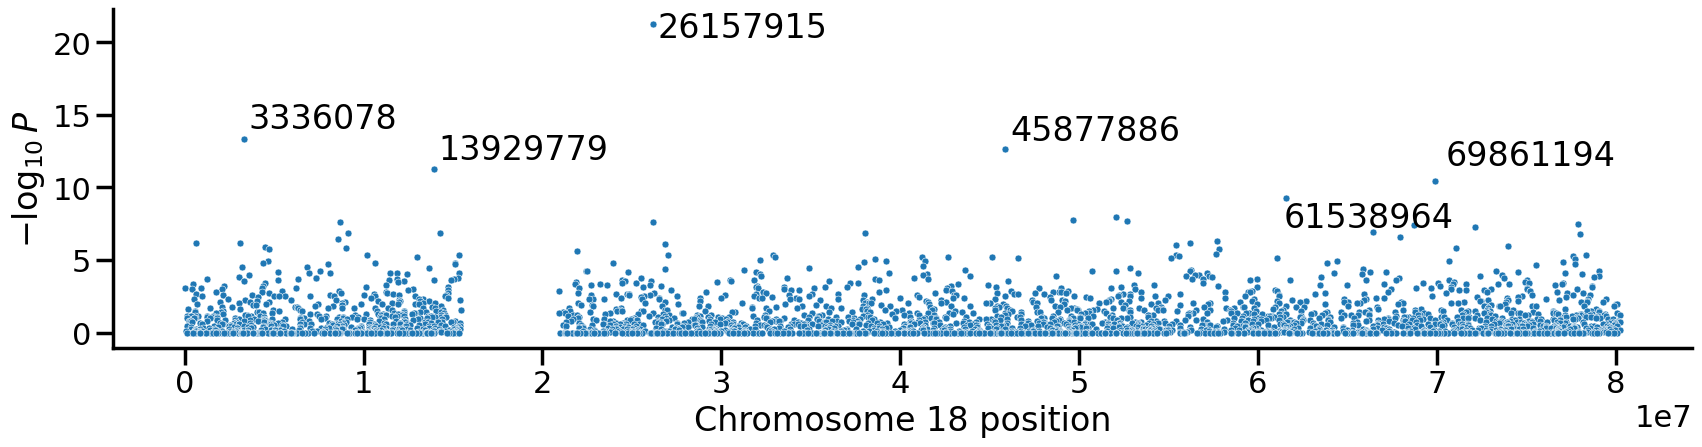

In [24]:
# create the manhatton plot
manhattan_plot = sns.relplot(
    data = variant_assoc,
    x = "POS",
    y = "-log(p_allele_count)",
    aspect = 3.5,
    s = 25)
# add a line indicating significance threshold to indicate variants with p < 1e-8
# manhattan_plot.ax.axhline(8, linestyle='--', linewidth=2, color="red")
# relabel x-axis
manhattan_plot.ax.set_xlabel("Chromosome 18 position")
# relabel y-axis
manhattan_plot.ax.set_ylabel(r"$-\log_{10}P$")
# get the top variants most strongly associated with EOPC status
top_vars = variant_assoc[variant_assoc["-log(p_allele_count)"] > 8]
# annotate these on the manhattan plot with the position along chromosome 18
annotations = top_vars.apply(lambda p : manhattan_plot.ax.annotate(p["POS"], (p["POS"], p["-log(p_allele_count)"])), axis=1).to_list()
adjust_text(annotations)
# save manhattan plot
# manhattan_plot.figure.savefig("results/manhattan_plot.png")
plt.show()